# Bitcoin Price Prediction using XGBoost

## Description

This notebook presents an end-to-end time series prediction project focused on forecasting Bitcoin prices using the XGBoost regression algorithm.

The goal is to predict **1-day future returns** of Bitcoin and reconstruct price estimates from those returns using lag features, rolling statistics, and temporal features.

Two datasets were explored:

- **CoinGecko API (Free Tier)**: Provides up to 365 days of historical Bitcoin data with OHLC and volume fields. Initial experiments using this short-term dataset yielded suboptimal results due to insufficient training data for a time series model.
- **Yahoo Finance (BTC-USD)**: Offers nearly **10 years** of daily Bitcoin data. After switching to this richer dataset, model performance improved significantly due to the longer history and more stable patterns.

## Project Highlights

- **Data Sources**: CoinGecko and Yahoo Finance (`yfinance`)
- **Techniques Used**:
  - Lagged features
  - Rolling window statistics
  - Temporal feature extraction (day of week, month, etc.)
  - Return-based modeling (predicting daily returns instead of raw prices)
- **Model**: XGBoost Regressor
- **Evaluation Metrics**: MAE, RMSE, and visual comparison of true vs. predicted price curves

## References
- [CoinGecko API Docs](https://www.coingecko.com/en/api)
- [Yahoo Finance Python API - yfinance](https://pypi.org/project/yfinance/)
- [XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/)

---

## loading the autoloaders

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Importing Modules

In [25]:
# Import necessary modules.
import pandas as pd
from bitcoin_utils import download_crypto_data, fetch_historical_bitcoin
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import numpy as np
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Xgboost on CoinGencko
---
## Step 1: Fetch Historical Bitcoin Data from CoinGecko

We start by collecting 365 days of daily Bitcoin price data using the free tier of the CoinGecko API. The data includes open, high, low, close, and volume.

This dataset is used for model experimentation. However, due to the limited size of just one year, results may not generalize well.

Data is stored in the variable `btc_cg_data`.


In [4]:
# Fetch Bitcoin historical data for the last 365 days using CoinGecko API.

btc_cg_data = fetch_historical_bitcoin()
btc_cg_data.head()

INFO:bitcoin_utils:Fetching historical Bitcoin data for the past 365 days from CoinGecko API.
INFO:bitcoin_utils:Data successfully fetched from CoinGecko.
INFO:bitcoin_utils:Bitcoin data successfully transformed into DataFrame.


,open,high,low,close,volume
Date,,,,,
2024-05-18,67053.123265,67053.123265,67053.123265,67053.123265,2.539779e+10
2024-05-19,66912.618614,66912.618614,66912.618614,66912.618614,1.302549e+10
2024-05-20,66252.712596,66252.712596,66252.712596,66252.712596,9.072735e+09
2024-05-21,71430.297002,71430.297002,71430.297002,71430.297002,3.592348e+10
2024-05-22,70189.835818,70189.835818,70189.835818,70189.835818,4.110506e+10


## Visualizing the data that we got from coin geek api

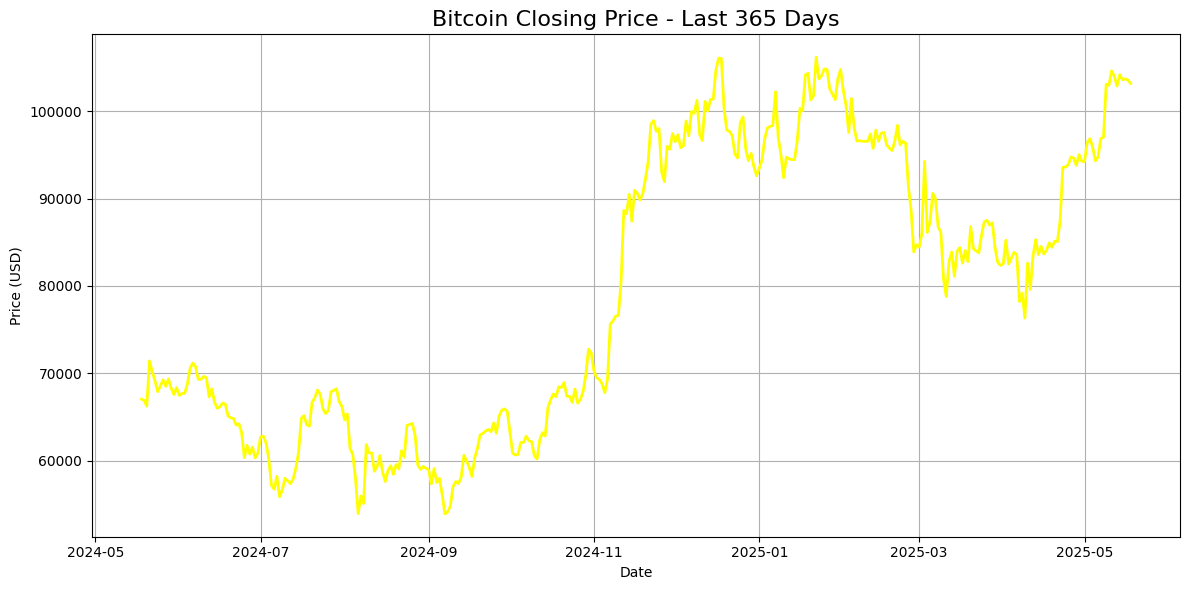

In [9]:

plt.figure(figsize=(12, 6))
plt.plot(btc_cg_data.index, btc_cg_data['close'], color='yellow', linewidth=2)
plt.title('Bitcoin Closing Price - Last 365 Days', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 2: Feature Engineering

We compute lagged returns, rolling statistics, and time-based features like day of week and month. These features are essential for modeling time-series behavior using machine learning.

Output is stored in `df_cg_features`.


In [10]:
def feature_engineering(df):
    df = df.copy()
    df['price'] = df['close']
    df['return_1d'] = df['price'].pct_change()
    df['lag_1'] = df['return_1d'].shift(1)
    df['lag_2'] = df['return_1d'].shift(2)
    df['lag_3'] = df['return_1d'].shift(3)
    df['ma_3'] = df['return_1d'].rolling(window=3).mean().shift(1)
    df['ma_7'] = df['return_1d'].rolling(window=7).mean().shift(1)
    df['std_3'] = df['return_1d'].rolling(window=3).std().shift(1)
    df['std_7'] = df['return_1d'].rolling(window=7).std().shift(1)
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df.dropna(inplace=True)
    return df


In [11]:
btc_cg_features = feature_engineering(btc_cg_data)
btc_cg_features.head()


,open,high,low,close,volume,price,return_1d,lag_1,lag_2,lag_3,ma_3,ma_7,std_3,std_7,dayofweek,month
Date,,,,,,,,,,,,,,,,
2024-05-26,69268.445590,69268.445590,69268.445590,69268.445590,1.592940e+10,69268.445590,0.010629,0.009328,-0.018426,-0.014370,-0.007823,0.003623,0.014991,0.034282,6,5
2024-05-27,68508.831109,68508.831109,68508.831109,68508.831109,1.124374e+10,68508.831109,-0.010966,0.010629,0.009328,-0.018426,0.000511,0.005440,0.016412,0.034266,0,5
2024-05-28,69367.238718,69367.238718,69367.238718,69367.238718,1.898381e+10,69367.238718,0.012530,-0.010966,0.010629,0.009328,0.002997,0.005283,0.012110,0.034351,1,5
2024-05-29,68316.635880,68316.635880,68316.635880,68316.635880,3.127812e+10,68316.635880,-0.015146,0.012530,-0.010966,0.010629,0.004064,-0.004092,0.013051,0.014187,2,5
2024-05-30,67577.265590,67577.265590,67577.265590,67577.265590,2.432069e+10,67577.265590,-0.010823,-0.015146,0.012530,-0.010966,-0.004527,-0.003774,0.014919,0.013862,3,5


## Step 3: Model Training with XGBoost

We train an XGBoost regression model to predict 1-day future returns based on the engineered features.

We then reconstruct price predictions from the predicted returns.

Outputs:
- Trained model: `model_cg`
- Predicted prices: `price_pred_cg`
- Actual prices: `price_actual_cg`


In [13]:
def train_model(df):
    X = df[['lag_1', 'lag_2', 'lag_3', 'ma_3', 'ma_7', 'std_3', 'std_7', 'dayofweek', 'month']]
    y = df['return_1d']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    price_base = df['price'].loc[X_train.index[-1]]
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    price_pred = [price_base * (1 + y_pred[0])]
    for i in range(1, len(y_pred)):
        price_pred.append(price_pred[i-1] * (1 + y_pred[i]))
    price_pred = pd.Series(price_pred, index=y_test.index)
    
    price_actual_test = df['price'].loc[y_test.index]
    
    mae = mean_absolute_error(price_actual_test, price_pred)
    rmse = np.sqrt(mean_squared_error(price_actual_test, price_pred))
    print(f"Training MAE: {mae:.4f}")
    print(f"Training RMSE: {rmse:.4f}")
    
    return model, price_pred, price_actual_test


In [14]:
model, price_pred_train, price_actual_train = train_model(btc_cg_features)


Training MAE: 10523.4817
Training RMSE: 11506.0155


## Step 4: Simulate Real-Time Bitcoin Price Prediction

To mimic a real-world scenario, we simulate day-by-day predictions using only past data at each time step.

This gives a more realistic assessment of how the model might perform in production.

Uses the model trained on `df_cg_features`.


In [16]:
def simulate_realtime_prediction(model, df_full):
    df = df_full.copy()
    df_fe = feature_engineering(df)
    
    predicted_prices = []
    actual_prices = []
    
    train_size = int(0.8 * len(df_fe))
    for i in range(train_size, len(df_fe)):
        X_live = df_fe.iloc[i][['lag_1', 'lag_2', 'lag_3', 'ma_3', 'ma_7', 'std_3', 'std_7', 'dayofweek', 'month']].values.reshape(1, -1)
        pred_return = model.predict(X_live)[0]
        
        if i == train_size:
            base_price = df_fe['price'].iloc[i - 1]
        
        pred_price = base_price * (1 + pred_return)
        predicted_prices.append(pred_price)
        actual_prices.append(df_fe['price'].iloc[i])
        base_price = pred_price
    
    predicted_prices = pd.Series(predicted_prices, index=df_fe.index[train_size:])
    actual_prices = pd.Series(actual_prices, index=df_fe.index[train_size:])
    
    mae = mean_absolute_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    print(f"Real-time simulation MAE: {mae:.4f}")
    print(f"Real-time simulation RMSE: {rmse:.4f}")
    
    plt.figure(figsize=(14,6))
    plt.plot(actual_prices.index, actual_prices, label='Actual Price', color='blue')
    plt.plot(predicted_prices.index, predicted_prices, label='Predicted Price', color='orange')
    plt.title("Bitcoin Price Prediction - Real-time Simulation")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()


Real-time simulation MAE: 10523.4817
Real-time simulation RMSE: 11506.0155


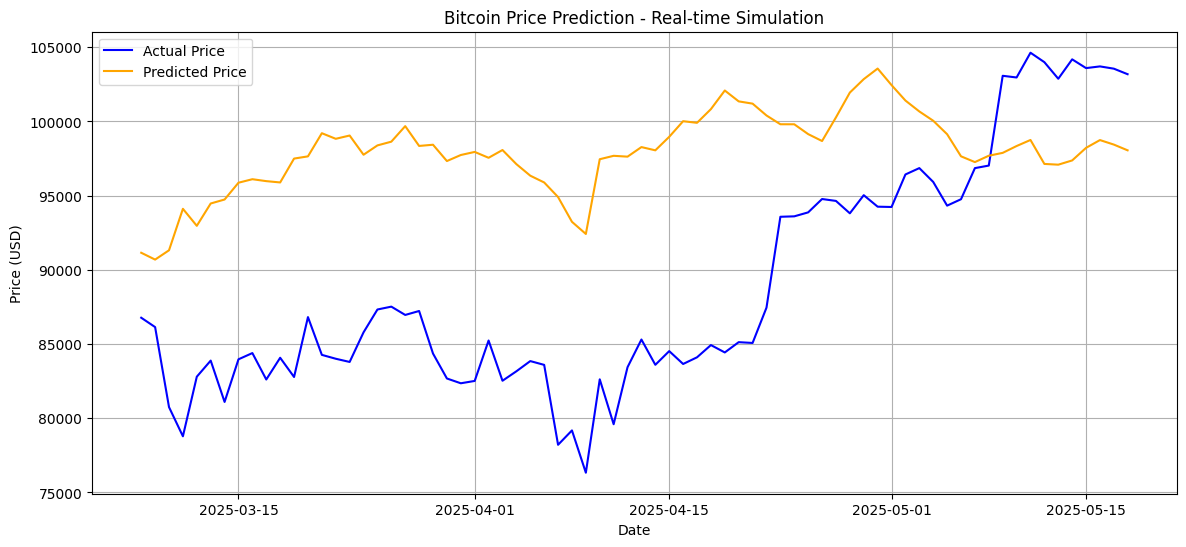

In [17]:
simulate_realtime_prediction(model, btc_cg_data)


## Training Performance

After training the XGBoost model on historical Bitcoin returns using engineered features, we observe the following evaluation metrics on the training set (reconstructed price):

- **Mean Absolute Error (MAE):** \$10,523.48  
- **Root Mean Squared Error (RMSE):** \$11,506.02

### Observations

- The **MAE** indicates that the model’s average absolute deviation from the actual price is over \$10K.
- The **RMSE**, being higher than MAE, suggests some larger outlier errors in the predictions.
- These high values are likely due to:
  - **Compounding of return prediction errors** during price reconstruction.
  - **High volatility** of Bitcoin prices, which are difficult to model using basic lagged return features.
- Model performance on training is not strong, indicating **underfitting** or **insufficient feature richness**.


# Xgboost on yahoo fiannce data

In this section, we use 10 years of daily historical Bitcoin data fetched from Yahoo Finance (`BTC-USD`) to perform time series forecasting using the XGBoost regression model.

Unlike CoinGecko's free tier, which restricts data to the past 365 days, Yahoo Finance provides a much richer dataset spanning almost a decade. This long-term data helps the model capture more stable and generalizable temporal patterns, improving predictive performance.

We follow these steps:
1. **Load Data** from Yahoo Finance using the utility function `fetch_yahoo_bitcoin_data()`.
2. **Perform Feature Engineering** using temporal and statistical lags of returns.
3. **Train an XGBoost Regressor** to predict 1-day future returns.
4. **Reconstruct Bitcoin Prices** from the predicted returns.
5. **Simulate Real-time Predictions** on unseen future days.
6. **Evaluate the Model** using MAE and RMSE.

We expect improved performance due to better training signal from long-term data.


In [20]:
btc_yf_data = download_crypto_data()
btc_yf_data.head()


INFO:bitcoin_utils:Starting download for BTC-USD from 2014-09-17


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
INFO:bitcoin_utils:Data for BTC-USD saved to BTC-USD-Historical.xlsx


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


## Visualizing the data the is from yahoo fiannce

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])


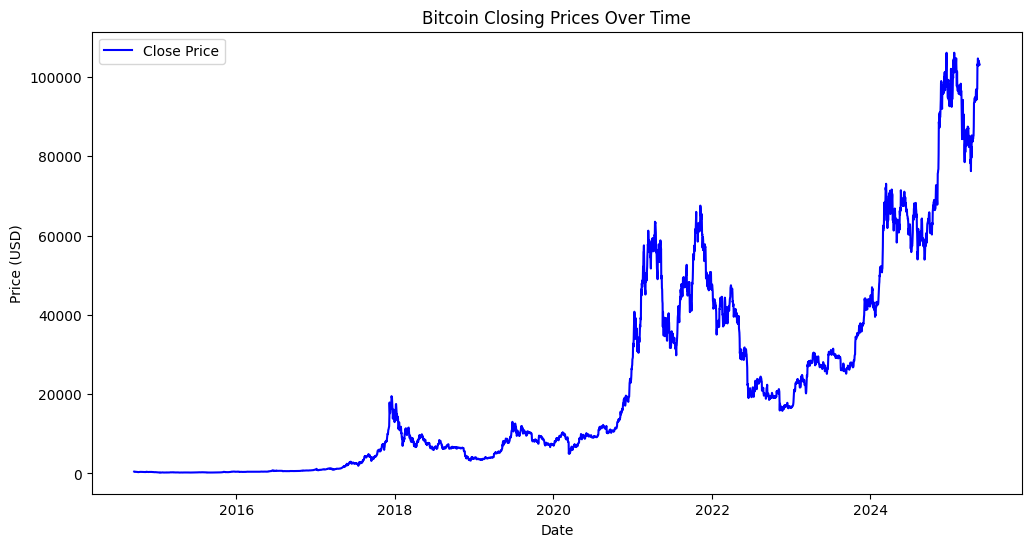

In [22]:
df = pd.read_excel("BTC-USD-Historical.xlsx", header=[0,1], index_col=0)

print(df.columns)

close_prices = df['Close']['BTC-USD']

close_prices.index = pd.to_datetime(close_prices.index)

plt.figure(figsize=(12,6))
plt.plot(close_prices.index, close_prices, label='Close Price', color='blue')
plt.title('Bitcoin Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Feature Engineering

We start by creating relevant features from the Bitcoin closing prices. 

- The target variable is the 1-day return, calculated as the percent change of the closing price.
- Predictor variables include lagged returns (previous days’ returns), rolling statistics (mean and standard deviation over different windows), and temporal features like day of the week and month.
- Finally, we drop rows with missing values resulting from lagging and rolling calculations.


In [24]:
df = pd.DataFrame(close_prices)
df.columns = ['price']

df['return_1d'] = df['price'].pct_change()

df['lag_1'] = df['return_1d'].shift(1)
df['lag_2'] = df['return_1d'].shift(2)
df['lag_3'] = df['return_1d'].shift(3)


df['ma_3'] = df['return_1d'].rolling(window=3).mean().shift(1)
df['ma_7'] = df['return_1d'].rolling(window=7).mean().shift(1)
df['std_3'] = df['return_1d'].rolling(window=3).std().shift(1)
df['std_7'] = df['return_1d'].rolling(window=7).std().shift(1)


df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month


df.dropna(inplace=True)
df.head()

,price,return_1d,lag_1,lag_2,lag_3,ma_3,ma_7,std_3,std_7,dayofweek,month
Date,,,,,,,,,,,
2014-09-25,411.574005,-0.027483,-0.028881,0.083647,0.008352,0.021040,-0.009653,0.057327,0.056546,3,9
2014-09-26,404.424988,-0.017370,-0.027483,-0.028881,0.083647,0.009095,-0.003304,0.064568,0.050568,4,9
2014-09-27,399.519989,-0.012128,-0.017370,-0.027483,-0.028881,-0.024578,0.004192,0.006281,0.042269,5,9
2014-09-28,377.181000,-0.055915,-0.012128,-0.017370,-0.027483,-0.018994,-0.002646,0.007805,0.040133,6,9
2014-09-29,375.467010,-0.004544,-0.055915,-0.012128,-0.017370,-0.028471,-0.007111,0.023911,0.044492,0,9


## Model Training and Prediction

Next, we prepare the data for modeling by separating predictors and target variables.

- We split the dataset into 80% training and 20% testing.
- We train an XGBoost regressor on the training data to predict next-day returns.
- Using the predicted returns on the test set, we reconstruct Bitcoin prices by cumulatively compounding the returns starting from the last training price.


In [26]:
X = df.drop(['price', 'return_1d'], axis=1)
y = df['return_1d']
price_actual = df['price'] 

split = int(0.8 * len(df))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
price_base = price_actual.iloc[split - 1]  

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

y_pred_returns = model.predict(X_test)

price_pred = [price_base * (1 + y_pred_returns[0])]
for i in range(1, len(y_pred_returns)):
    price_pred.append(price_pred[i - 1] * (1 + y_pred_returns[i]))

price_pred = pd.Series(price_pred, index=y_test.index)
price_actual_test = price_actual.iloc[split:]

mae = mean_absolute_error(price_actual_test, price_pred)
rmse = np.sqrt(mean_squared_error(price_actual_test, price_pred))
print(f"Improved MAE: {mae:.2f}")
print(f"Improved RMSE: {rmse:.2f}")


Improved MAE: 7096.99
Improved RMSE: 9432.30


## Visualization of Actual vs Predicted Prices

Finally, we visualize the actual and predicted Bitcoin prices over the test period to assess the model's predictive performance visually.


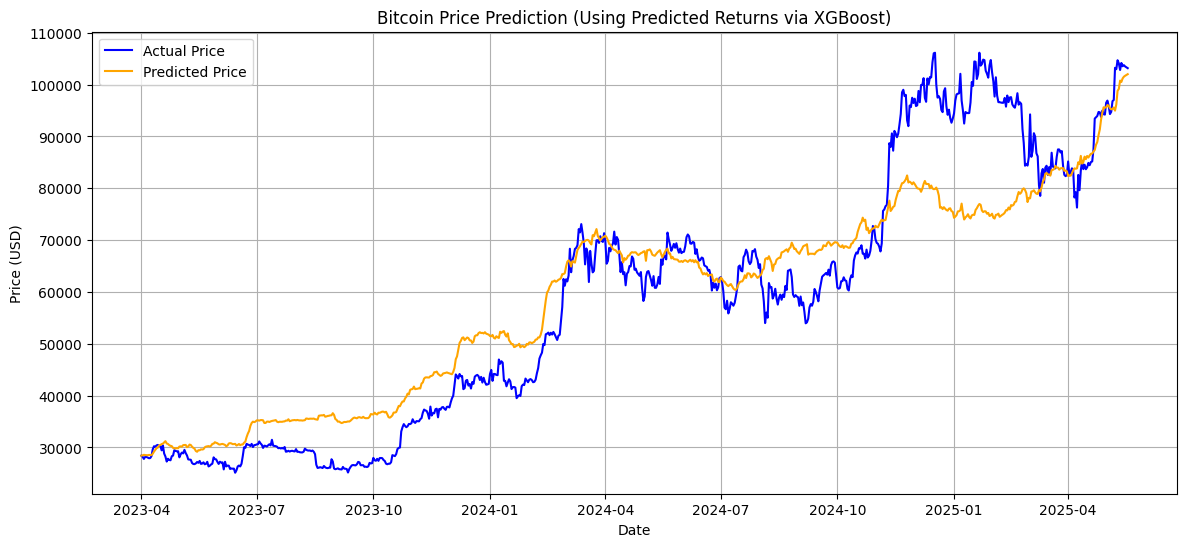

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(price_actual_test.index, price_actual_test, label='Actual Price', color='blue')
plt.plot(price_pred.index, price_pred, label='Predicted Price', color='orange')
plt.title("Bitcoin Price Prediction (Using Predicted Returns via XGBoost)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


## Model Performance

The XGBoost model was evaluated on the test set, and the following error metrics were obtained:

- **Mean Absolute Error (MAE):** 7096.99  
- **Root Mean Squared Error (RMSE):** 9432.30

These metrics indicate the average and squared difference between the predicted and actual Bitcoin prices, respectively.


# Comparison Between CoinGecko and Yahoo Finance Models

### Model Performance Summary

| Metric           | CoinGecko Data Model | Yahoo Finance Data Model |
|------------------|---------------------|-------------------------|
| MAE     | 10,523.48           |  7,096.99  |
| RMSE    | 11,506.02           |     9,432.30  |


### Comparison Insights

- The **CoinGecko model** was trained on approximately 1 year of historical Bitcoin price data. It resulted in higher error metrics (MAE ≈ 10,523 and RMSE ≈ 11,506) during training, indicating less precise predictions.

- The **Yahoo Finance model** utilized 10 years of historical data, which provided a richer dataset for feature extraction and training. As a result, it achieved significantly lower MAE (7,097) and RMSE (9,432) on the test set, reflecting better prediction accuracy.

- The longer historical data in the Yahoo Finance dataset allowed the model to better capture underlying trends and seasonal patterns, thus improving its predictive capability.

- This comparison highlights the impact of data volume and quality on model performance in time series forecasting, especially for highly volatile assets like Bitcoin.

---

## Summary

In this project, we developed XGBoost models to predict Bitcoin prices by forecasting 1-day returns and reconstructing prices. Two different data sources were used: CoinGecko (1 year) and Yahoo Finance (10 years).

- The Yahoo Finance model outperformed the CoinGecko model by a considerable margin, showing that more extensive historical data can lead to more accurate price predictions.
- Both models leveraged lagged returns, rolling statistics, and temporal features to inform predictions.
- While the improved Yahoo Finance model achieves reasonable accuracy, Bitcoin’s inherent volatility still poses challenges for precise forecasting.
- Future work can focus on incorporating additional features such as volume, sentiment analysis, or external macroeconomic indicators to further enhance model accuracy.

Overall, the project demonstrates the importance of comprehensive data and feature engineering in time series forecasting using machine learning techniques like XGBoost.
